In [1]:
#imports

import numpy as np
import pandas as pd
import os
import glob
import cv2
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import to_categorical
from keras.utils import np_utils
from PIL import ImageFile 
import matplotlib.pyplot as plt
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# **Importing data**

In [2]:
data_dir = "../input/state-farm-distracted-driver-detection/imgs"
test_data_dir = os.path.join(data_dir,"test")
train_data_dir = os.path.join(data_dir,"train")

# **Resising the image**

In [3]:
def resize(path, img_height, img_width):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_height, img_width))
    return resized

# Making training data

In [4]:
def get_train_data():
    X_train = []
    y_train = []
    
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join(train_data_dir, 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = resize(fl, 64, 64)
            #img = np.expand_dims(img, axis=0)
            X_train.append(img)
            y_train.append(j)
    return X_train, y_train

In [5]:
X, y = get_train_data()

Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9


In [6]:
print('Shape of X is',len(X))
print('Shape of Y is',len(y))

Shape of X is 22424
Shape of Y is 22424


# **Spliting test data from Training data**
Since test data provided doesn't have any labels.

In [7]:
y = np_utils.to_categorical(y, num_classes=10)

In [8]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify=y,random_state=42)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

print('The x_train shape is',x_train.shape)
print('The x_test shape is',x_test.shape)

print('The y_train shape is',y_train.shape)
print('The y_test shape is',y_test.shape)

The x_train shape is (17939, 64, 64, 3)
The x_test shape is (4485, 64, 64, 3)
The y_train shape is (17939, 10)
The y_test shape is (4485, 10)


# Defining VGG Model

In [10]:
vgg_model = VGG16(input_shape=[64,64,3], weights='imagenet', include_top=False)
vgg_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

# adding Dense layers

In [11]:
x = Flatten()(vgg_model.output)
#x = Dense(1000, activation='relu')(x)
prediction = Dense(10, activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=vgg_model.input, outputs=prediction)

# After adding the layesr viewing the model summary

In [13]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
callbacks = [EarlyStopping(monitor='val_acc',patience=5), ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True, verbose=0, mode='auto'),]

# Model fitting

In [16]:
history = model.fit(x_train,y_train,batch_size=128,epochs=10,validation_data=(x_test,y_test),shuffle=True,callbacks=callbacks)

Epoch 1/10
141/141 [==============================] - 218s 1s/step - loss: 7.2621 - accuracy: 0.1063 - val_loss: 15.0693 - val_accuracy: 0.1032
Epoch 2/10
141/141 [==============================] - 205s 1s/step - loss: 3.0917 - accuracy: 0.1501 - val_loss: 1.1173 - val_accuracy: 0.5458
Epoch 3/10
141/141 [==============================] - 205s 1s/step - loss: 0.8830 - accuracy: 0.6651 - val_loss: 0.3661 - val_accuracy: 0.8874
Epoch 4/10
141/141 [==============================] - 205s 1s/step - loss: 0.3037 - accuracy: 0.9065 - val_loss: 0.3481 - val_accuracy: 0.8861
Epoch 5/10
141/141 [==============================] - 205s 1s/step - loss: 0.1561 - accuracy: 0.9527 - val_loss: 0.1567 - val_accuracy: 0.9610
Epoch 6/10
141/141 [==============================] - 205s 1s/step - loss: 0.1282 - accuracy: 0.9627 - val_loss: 0.1280 - val_accuracy: 0.9652
Epoch 7/10
141/141 [==============================] - 205s 1s/step - loss: 0.0998 - accuracy: 0.9704 - val_loss: 0.0906 - val_accuracy: 0.976

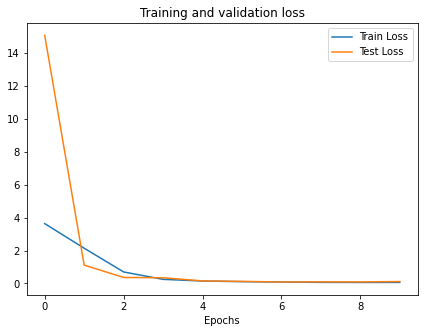

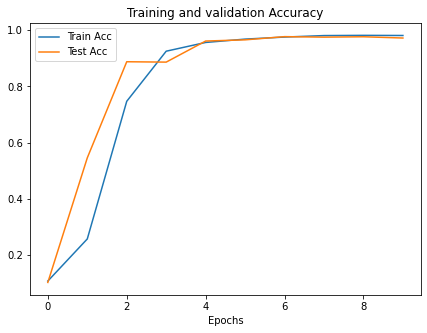

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.figure(figsize=(7, 5))
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend(['Train Loss','Test Loss'], loc='best')
plt.savefig('losses.png')

plt.figure(figsize=(7, 5))
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.xlabel('Epochs')
plt.title('Training and validation Accuracy')
plt.legend(['Train Acc','Test Acc'], loc='best')
plt.savefig('accuracy.png')

# Predicting on test data

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sns

In [19]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels
    predictions = n_predictions

    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(10,7), fontsize=20)

In [20]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [21]:
class_names=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
y_pred = model.predict(x_test,verbose=1)

141/141 [==============================] - 42s 288ms/step


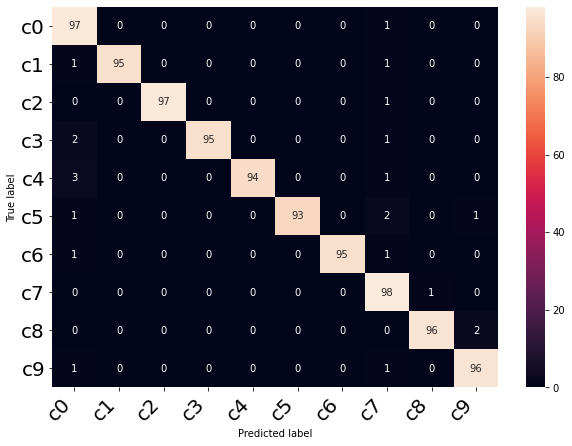

In [22]:
print_heatmap(y_test,y_pred,class_names)

In [23]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

In [24]:
from sklearn.metrics import classification_report
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred, target_names=activity_map.keys()))

              precision    recall  f1-score   support

          c0       0.89      0.98      0.93       498
          c1       0.99      0.96      0.97       453
          c2       0.99      0.97      0.98       464
          c3       0.99      0.95      0.97       469
          c4       0.98      0.95      0.96       465
          c5       1.00      0.93      0.96       463
          c6       0.99      0.95      0.97       465
          c7       0.88      0.98      0.93       400
          c8       0.96      0.96      0.96       382
          c9       0.95      0.97      0.96       426

    accuracy                           0.96      4485
   macro avg       0.96      0.96      0.96      4485
weighted avg       0.96      0.96      0.96      4485



# Predicting on Orginial test folder

In [25]:
def plot_test_class(model, test_files, image_number, color_type=3):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=128, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [26]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

def load_test(img_rows=64, img_cols=64, color_type=3):
    path = os.path.join(test_data_dir, '*.jpg')
    print(path)
    print(test_data_dir)
    files = sorted(glob.glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [27]:
img_rows = 64
img_cols = 64
color_type = 3

test_files, test_targets = read_and_normalize_sampled_test_data(img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

../input/state-farm-distracted-driver-detection/imgs/test/*.jpg
../input/state-farm-distracted-driver-detection/imgs/test


100%|██████████| 79726/79726 [17:46<00:00, 74.72it/s]


Test shape: (79726, 64, 64, 3)
79726 Test samples


1/1 [==============================] - 0s 168ms/step
Y prediction: [[4.0073977e-03 2.5007415e-03 1.6348965e-02 3.1333271e-04 1.8269089e-03
  2.6618557e-03 1.9271277e-02 7.6598632e-01 1.8438783e-01 2.6954242e-03]]
Predicted: Reaching behind


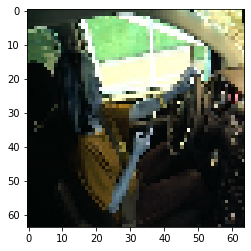

In [28]:
plot_test_class(model, test_files, 1002) 

1/1 [==============================] - 0s 33ms/step
Y prediction: [[5.5561387e-14 1.5734749e-20 5.1469282e-17 2.7747495e-09 1.8688271e-11
  1.0000000e+00 1.8366683e-13 6.1218330e-14 5.2606102e-09 4.2405545e-16]]
Predicted: Operating the radio


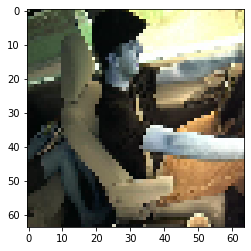

In [29]:
plot_test_class(model, test_files, 1) 

1/1 [==============================] - 0s 33ms/step
Y prediction: [[1.43620260e-09 1.97724161e-13 3.16166039e-13 1.00000000e+00
  1.15221388e-08 1.56059041e-08 1.04919365e-10 6.84034995e-10
  5.33552260e-08 1.09716869e-12]]
Predicted: Texting - left


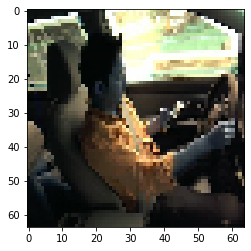

In [30]:
plot_test_class(model, test_files, 143) 

1/1 [==============================] - 0s 34ms/step
Y prediction: [[9.9475151e-01 2.9158358e-05 6.6438486e-05 3.7353409e-03 5.0846220e-04
  1.0179140e-04 4.3385666e-05 1.2951790e-04 4.4964673e-04 1.8475686e-04]]
Predicted: Safe driving


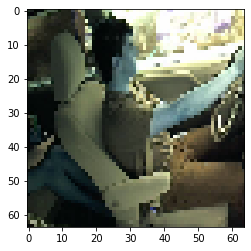

In [31]:
plot_test_class(model, test_files, 6432) 

1/1 [==============================] - 0s 33ms/step
Y prediction: [[4.8130437e-07 3.8970671e-07 1.4803486e-10 2.9635592e-09 6.3504885e-08
  8.6145883e-07 4.5782489e-08 9.9998498e-01 1.1320484e-05 1.9122858e-06]]
Predicted: Reaching behind


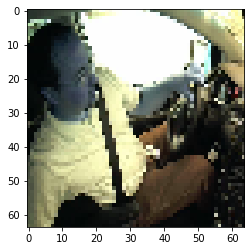

In [32]:
plot_test_class(model, test_files, 67432) 